In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Read the synchroized CGM data

In [13]:
data = pd.read_csv('data/cgm_to_meal_start.csv', parse_dates=['time_insulin', 'time_cgm'])
data = data.dropna()
data = data.reset_index(drop=True)

### Plot the Auto-correlation function (ACF) for Moving Average (MA) parameters

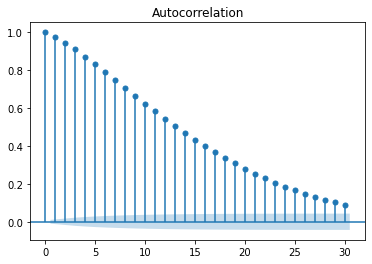

In [14]:
_ = plot_acf(data['cgm'].to_numpy(), lags=30)

### Plot the PACF for Auto-regression (AR) parameters

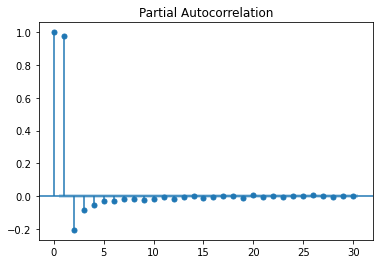

In [15]:
_ = plot_pacf(data['cgm'].to_numpy(), lags=30)

### Fit a SARIMA model on subset of data

In [6]:
demo_data = data['cgm']

DEMO_TRAIN_DATA_POINTS = 10000
FORECAST_POINTS = 100

demo_train_start_idx = np.random.randint(0, len(demo_data) - DEMO_TRAIN_DATA_POINTS)
demo_train_end_idx = demo_train_start_idx + DEMO_TRAIN_DATA_POINTS

demo_train_data = demo_data[demo_train_start_idx : demo_train_end_idx]
demo_test_data = demo_data[demo_train_end_idx : demo_train_end_idx + FORECAST_POINTS]

#### SARIMA model with seasonality parameters

In [7]:
order = (5, 0, 20)
seasonal_order = (1, 0, 1, 100)
sarima_model = SARIMAX(demo_train_data, order=order, seasonal_order=seasonal_order)

#### Fit the model

In [8]:
fitted_model = sarima_model.fit()
print(fitted_model.summary())

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                       SARIMAX Results                                        
Dep. Variable:                                    cgm   No. Observations:                10000
Model:             SARIMAX(5, 0, 20)x(1, 0, [1], 100)   Log Likelihood              -39189.001
Date:                                Fri, 04 Dec 2020   AIC                          78434.001
Time:                                        12:18:28   BIC                          78635.891
Sample:                                             0   HQIC                         78502.340
                                              - 10000                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6877      0.094     -7.289      0.000      -0.873      -0.503
ar.

In [9]:
predictor_model = SARIMAX(demo_data[:demo_train_end_idx + FORECAST_POINTS], order=order)
predictor_model = predictor_model.filter(fitted_model.params)
predicted_cgm_values = predictor_model.predict()[demo_train_end_idx : demo_train_end_idx + FORECAST_POINTS]

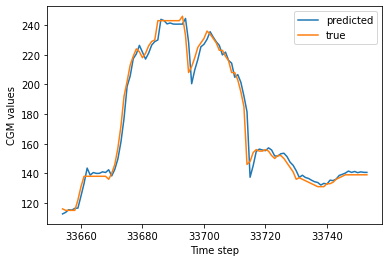

Mean absolute percent error:  0.023


In [10]:
plt.plot(predicted_cgm_values, label='predicted')
plt.plot(demo_test_data, label='true')
plt.ylabel('CGM values')
plt.xlabel('Time step')
plt.legend()
plt.show()

residuals = demo_test_data - predicted_cgm_values
print("Mean absolute percent error: ", round(np.mean(abs(residuals/demo_test_data)), 4))

#### Final SARIMA model without sesonality

#### We went with this because it gives equally good results and it takes much less time to run as compared to SARIMA with seasonality.

In [17]:
order = (5, 0, 20)
sarima_model = SARIMAX(demo_train_data, order=order)

#### Fit the model

In [18]:
fitted_model = sarima_model.fit()
print(fitted_model.summary())

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                    cgm   No. Observations:                10000
Model:              SARIMAX(5, 0, 20)   Log Likelihood              -39240.095
Date:                Fri, 04 Dec 2020   AIC                          78532.190
Time:                        15:10:43   BIC                          78719.659
Sample:                             0   HQIC                         78595.647
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0482      0.612     -0.079      0.937      -1.247       1.151
ar.L2          0.9041      0.597      1.515      0.130      -0.266       2.074
ar.L3          0.6348      0.508      1.249      0.2

#### Evaluate the fitted model on test points

In [19]:
predictor_model = SARIMAX(demo_data[:demo_train_end_idx + FORECAST_POINTS], order=order)
predictor_model = predictor_model.filter(fitted_model.params)
predicted_cgm_values = predictor_model.predict()[demo_train_end_idx : demo_train_end_idx + FORECAST_POINTS]

#### Plot the predicted vs true CGM values

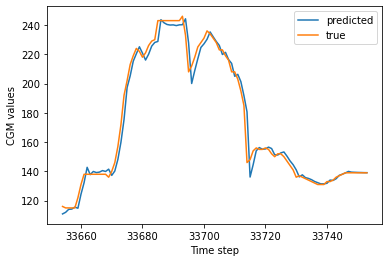

Mean absolute percent error:  0.0221


In [20]:
plt.plot(predicted_cgm_values, label='predicted')
plt.plot(demo_test_data, label='true')
plt.ylabel('CGM values')
plt.xlabel('Time step')
plt.legend()
plt.show()

residuals = demo_test_data - predicted_cgm_values
print("Mean absolute percent error: ", round(np.mean(abs(residuals/demo_test_data)), 4))

### Meal prediction demo on subset of data

#### Extract non-meal data from the training set

In [21]:
cgm_data = data

DEMO_DATA_POINTS = 20000
TRAIN_PERCENT = 0.70

demo_data_start_idx = np.random.randint(0, len(cgm_data) - DEMO_DATA_POINTS)
demo_data = cgm_data[demo_data_start_idx : demo_data_start_idx + DEMO_DATA_POINTS]

demo_train_data_end_idx = int(DEMO_DATA_POINTS * TRAIN_PERCENT)
demo_train_data = demo_data[ : demo_train_data_end_idx]

# non meal data
demo_train_data = demo_train_data.loc[(demo_train_data['meal_start'] == 0) & (demo_train_data['meal'] == 0)]['cgm']
demo_test_data = demo_data[demo_train_data_end_idx : ]
demo_test_cgm_data = demo_test_data['cgm']

#### Fit the model and make predictions

In [22]:
sarima_model = SARIMAX(demo_train_data, order=order)
fitted_model = sarima_model.fit()
print(fitted_model.summary())

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                    cgm   No. Observations:                12505
Model:              SARIMAX(5, 0, 20)   Log Likelihood              -50636.270
Date:                Fri, 04 Dec 2020   AIC                         101324.540
Time:                        15:11:41   BIC                         101517.821
Sample:                             0   HQIC                        101389.244
                              - 12505                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8596      0.043    -20.020      0.000      -0.944      -0.775
ar.L2          1.5919      0.028     56.199      0.000       1.536       1.647
ar.L3          1.7191      0.073     23.472      0.0

#### Get predictions on test data

In [23]:
predictor_model = SARIMAX(demo_test_cgm_data, order=order)
predictor_model = predictor_model.filter(fitted_model.params)
predicted_cgm_values = predictor_model.predict()

predicted_cgm_values = predicted_cgm_values.to_numpy()
demo_test_cgm_data = demo_test_cgm_data.to_numpy()

#### Meal vs non-meal values for $|CGM_{predicted} - CGM_{actual}|$

Text(1000, 20, 'FPR-- non-meal-points \n detected \n as meal')

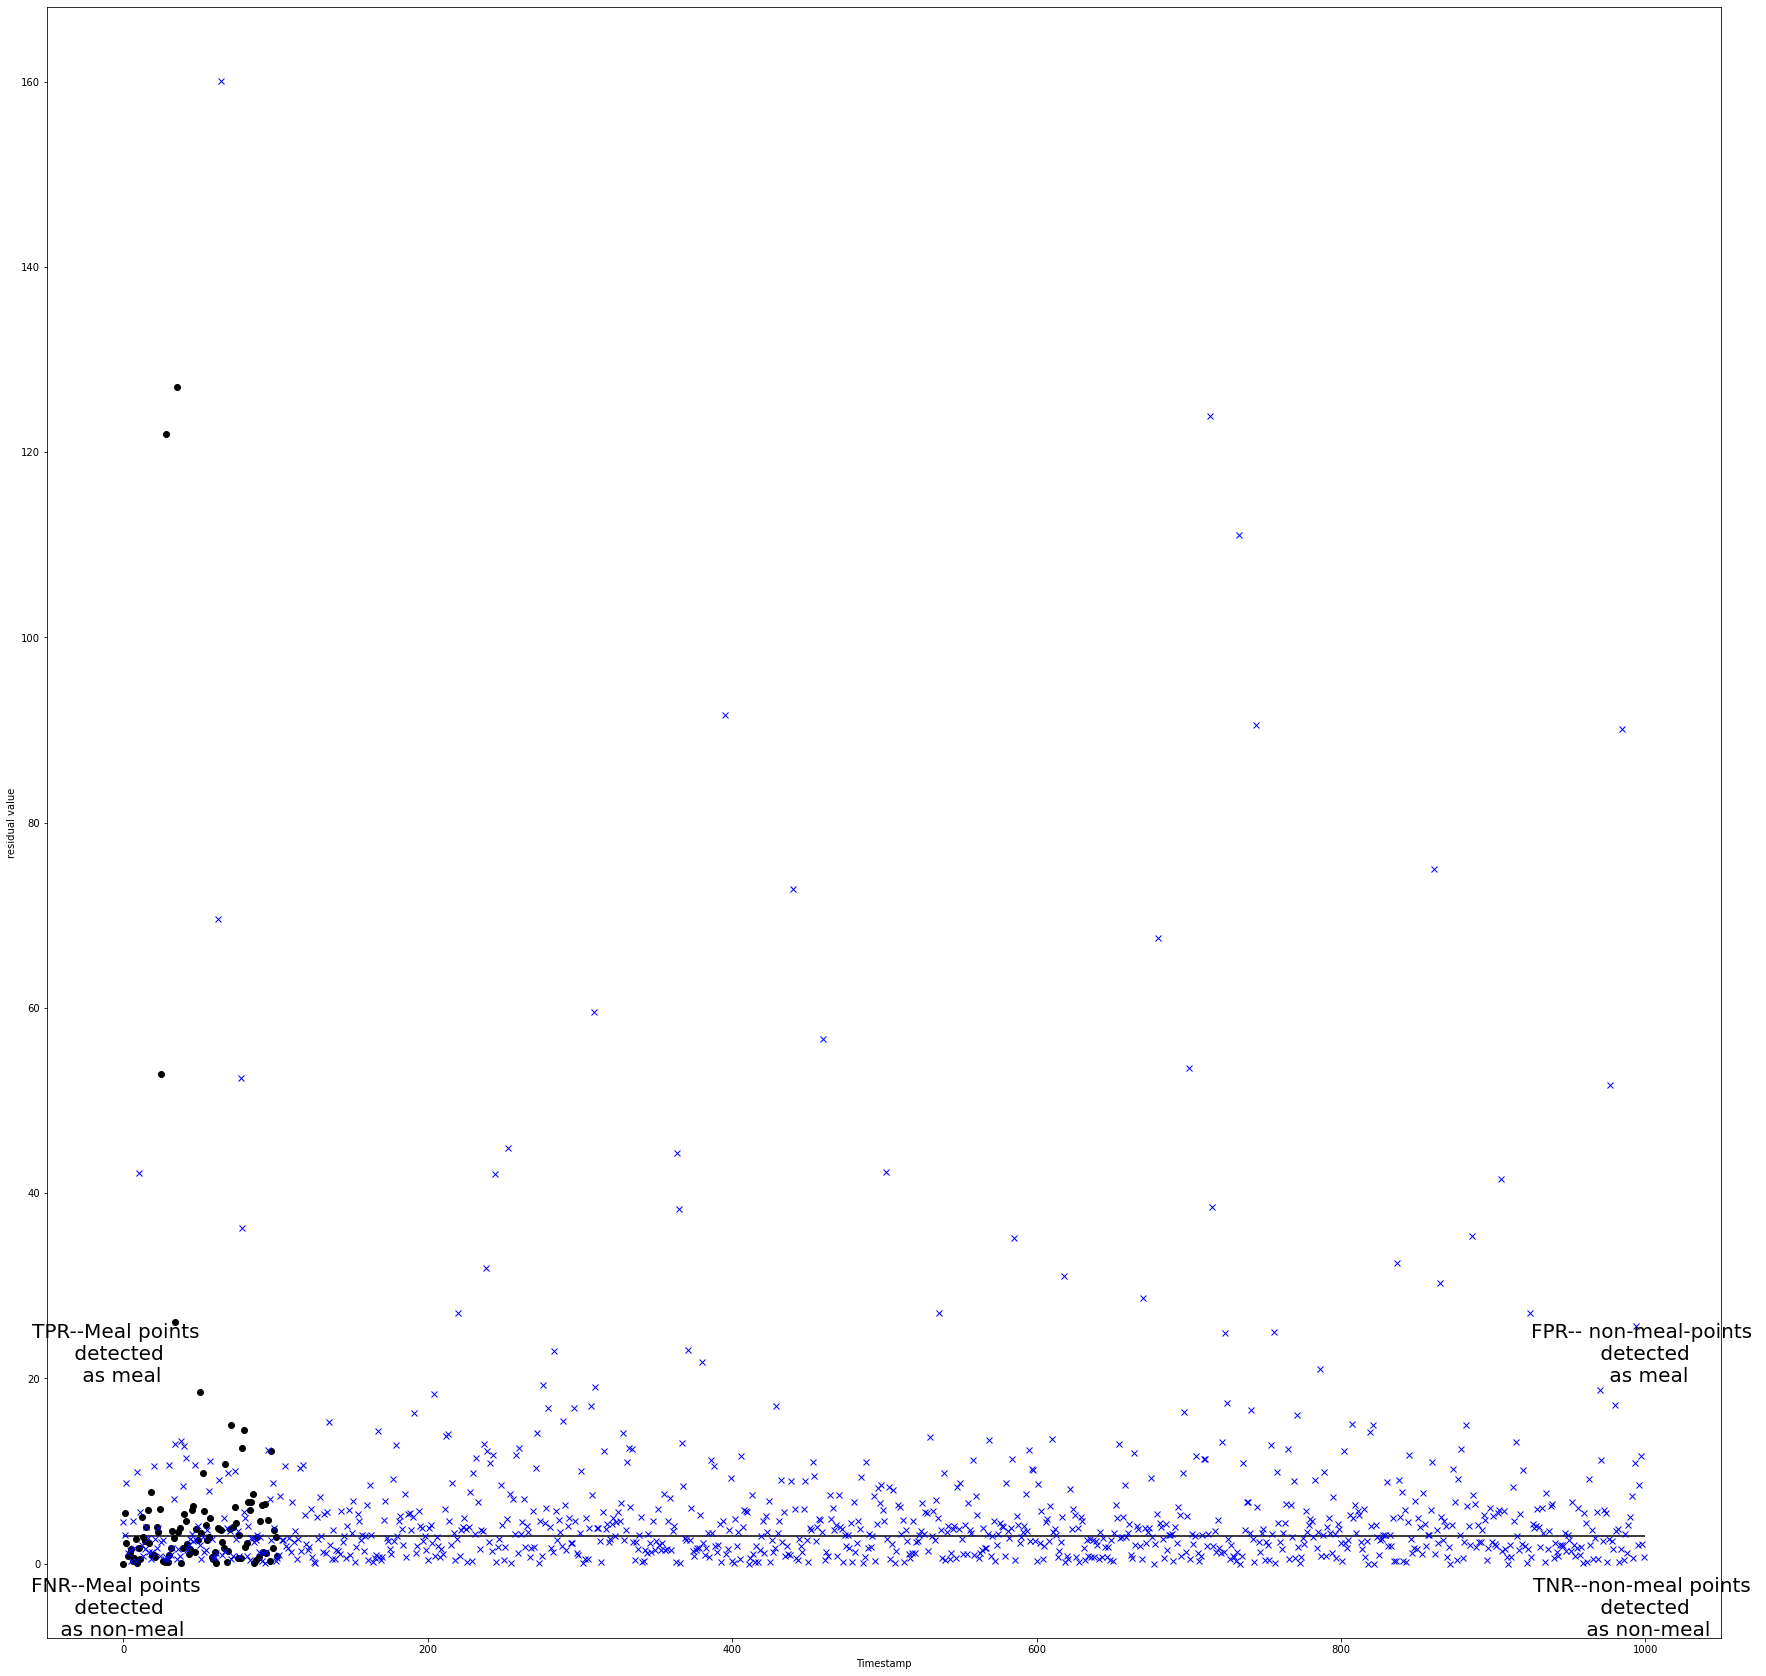

In [24]:
meal_diff = []
non_meal_diff = []

meal_truth = (demo_test_data['meal_start'] == 1).to_numpy()
meal_indices = np.where(meal_truth == True)[0]
non_meal_indices = np.where(meal_truth == False)[0]

for idx in meal_indices:
    meal_diff.append(abs(predicted_cgm_values[idx] - demo_test_cgm_data[idx]))

for idx in non_meal_indices:
    non_meal_diff.append(abs(predicted_cgm_values[idx] - demo_test_cgm_data[idx]))

meal_diff = np.array(meal_diff)
non_meal_diff = np.array(non_meal_diff)
non_meal_diff = np.random.choice(non_meal_diff, 1000, replace=False)


plt.figure(figsize=(30, 30))
plt.plot(meal_diff, 'o', color='black')
plt.plot(non_meal_diff, 'x', color='blue')
plt.hlines(3.0, 0, 1000, color='black')
plt.xlabel('Timestamp')
plt.ylabel('residual value')

plt.text(-3, -7.5, "FNR--Meal points \n detected \n as non-meal", wrap=True, ha='center', color='black', fontsize=20)
plt.text(1000, -7.5, "TNR--non-meal points \n detected \n as non-meal", wrap=True, ha='center', color='black', fontsize=20)
plt.text(-3, 20, "TPR--Meal points \n detected \n as meal", wrap=True, ha='center', color='black', fontsize=20)
plt.text(1000, 20, "FPR-- non-meal-points \n detected \n as meal", wrap=True, ha='center', color='black', fontsize=20)

### Metric evaluation for the subset
#### Threshold = $|CGM_{predicted} - CGM_{actual}|$

In [25]:
threshold = 4.5

non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]

true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()

false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()

print(" TPR (meal as meal)", true_positive, "\n FPR (non-meal as meal)", false_positive, " \n TNR (non-meal as non-meal)", true_negative, "\n FNR (meal as non-meal)", false_negative)

detected_correctly = non_meal_diff[non_meal_diff < threshold].__len__() + meal_diff[meal_diff >= threshold].__len__()
total_points = meal_diff.__len__() + non_meal_diff.__len__()
print(" Accuracy: ", (detected_correctly) / (total_points) )

 TPR (meal as meal) 0.30392156862745096 
 FPR (non-meal as meal) 0.343  
 TNR (non-meal as non-meal) 0.657 
 FNR (meal as non-meal) 0.696078431372549
 Accuracy:  0.6243194192377496


## Evaluation on entire dataset by taking random K-folds over data

In [28]:
K = 25
data_per_fold = 10000
train_percent = 0.70

all_true_positive = []
all_true_negative = []
all_false_positive = []
all_false_negative = []
all_accuracies = []

for fold_no in range(K):
    # select a random start index for the fold
    fold_start_idx = np.random.randint(0, len(data) - data_per_fold)
    
    fold_end_idx = fold_start_idx + data_per_fold
    fold_data = data[fold_start_idx : fold_end_idx]
    fold_train_end_idx = int(train_percent * fold_data.__len__())
    
    fold_train_data = fold_data[0 : fold_train_end_idx]
    fold_test_data = fold_data[fold_train_end_idx : ]
    
    # apply SARIMA model on the train data after removing meal points from it
    fold_train_data_no_meal = fold_train_data.loc[(fold_train_data['meal_start'] == 0) & (fold_train_data['meal'] == 0)]
    fold_cgm_train_no_meal = fold_train_data_no_meal['cgm'].to_numpy()
    
    # train the model
    model = SARIMAX(fold_cgm_train_no_meal, order=order).fit()
    model_params = model.params
    
    fold_cgm_data = fold_data['cgm'].to_numpy()
    # now make a new model with the fitted values from the trained model
    predictor_model = SARIMAX(fold_cgm_data, order=order)
    predictor_model = predictor_model.filter(model_params)
    
    predicted_cgm_values = predictor_model.predict()
    
    # compute meal and no-meal here
    
    meal_diff = []
    non_meal_diff = []
    meal_truth = (fold_data['meal_start'] == 1).to_numpy()
    meal_indices = np.where(meal_truth == True)[0]
    non_meal_indices = np.where(meal_truth == False)[0]

    for idx in meal_indices:
        meal_diff.append(abs(predicted_cgm_values[idx] - fold_cgm_data[idx]))

    for idx in non_meal_indices:
        non_meal_diff.append(abs(predicted_cgm_values[idx] - fold_cgm_data[idx]))
    
    meal_diff = np.array(meal_diff)
    non_meal_diff = np.array(non_meal_diff)
    
    print("#" * 10)
    
    threshold = 4.5
    
    true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
    true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()
    
    false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
    false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()
    
    print(" TPR (meal as meal)", true_positive, "\n FPR (non-meal as meal)", false_positive, " \n TNR (non-meal as non-meal)", true_negative, "\n FNR (meal as non-meal)", false_negative)

    detected_correctly = non_meal_diff[non_meal_diff < threshold].__len__() + meal_diff[meal_diff >= threshold].__len__()
    total_points = meal_diff.__len__() + non_meal_diff.__len__()
    accuracy = (detected_correctly) / (total_points)
    print(" Accuracy: ", accuracy )
    
    print("#" * 10)
    
    all_true_positive.append(true_positive)
    all_true_negative.append(true_negative)
    all_false_positive.append(false_positive)
    all_false_negative.append(false_negative)
    all_accuracies.append(accuracy)

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3930635838150289 
 FPR (non-meal as meal) 0.34456090363284825  
 TNR (non-meal as non-meal) 0.6554390963671517 
 FNR (meal as non-meal) 0.6069364161849711
 Accuracy:  0.6509
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3393939393939394 
 FPR (non-meal as meal) 0.3353329944077275  
 TNR (non-meal as non-meal) 0.6646670055922725 
 FNR (meal as non-meal) 0.6606060606060606
 Accuracy:  0.6593
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.30434782608695654 
 FPR (non-meal as meal) 0.35228198859005705  
 TNR (non-meal as non-meal) 0.6477180114099429 
 FNR (meal as non-meal) 0.6956521739130435
 Accuracy:  0.6414
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.6878612716763006 
 FPR (non-meal as meal) 0.6966520810013229  
 TNR (non-meal as non-meal) 0.30334791899867714 
 FNR (meal as non-meal) 0.31213872832369943
 Accuracy:  0.31
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.31137724550898205 
 FPR (non-meal as meal) 0.33357062951286487  
 TNR (non-meal as non-meal) 0.6664293704871351 
 FNR (meal as non-meal) 0.688622754491018
 Accuracy:  0.6605
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.38922155688622756 
 FPR (non-meal as meal) 0.34007932472287195  
 TNR (non-meal as non-meal) 0.659920675277128 
 FNR (meal as non-meal) 0.6107784431137725
 Accuracy:  0.6554
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.32335329341317365 
 FPR (non-meal as meal) 0.3498423675378826  
 TNR (non-meal as non-meal) 0.6501576324621173 
 FNR (meal as non-meal) 0.6766467065868264
 Accuracy:  0.6447
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3333333333333333 
 FPR (non-meal as meal) 0.3496695475343162  
 TNR (non-meal as non-meal) 0.6503304524656838 
 FNR (meal as non-meal) 0.6666666666666666
 Accuracy:  0.6451
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.6206896551724138 
 FPR (non-meal as meal) 0.6043150824343578  
 TNR (non-meal as non-meal) 0.39568491756564217 
 FNR (meal as non-meal) 0.3793103448275862
 Accuracy:  0.3996
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.6631016042780749 
 FPR (non-meal as meal) 0.690410679710588  
 TNR (non-meal as non-meal) 0.309589320289412 
 FNR (meal as non-meal) 0.33689839572192515
 Accuracy:  0.3162
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3567251461988304 
 FPR (non-meal as meal) 0.341031641062163  
 TNR (non-meal as non-meal) 0.658968358937837 
 FNR (meal as non-meal) 0.6432748538011696
 Accuracy:  0.6538
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.32967032967032966 
 FPR (non-meal as meal) 0.3360154817681809  
 TNR (non-meal as non-meal) 0.6639845182318191 
 FNR (meal as non-meal) 0.6703296703296703
 Accuracy:  0.6579
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3231707317073171 
 FPR (non-meal as meal) 0.34017893452623016  
 TNR (non-meal as non-meal) 0.6598210654737698 
 FNR (meal as non-meal) 0.676829268292683
 Accuracy:  0.6543
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.22702702702702704 
 FPR (non-meal as meal) 0.304635761589404  
 TNR (non-meal as non-meal) 0.695364238410596 
 FNR (meal as non-meal) 0.772972972972973
 Accuracy:  0.6867
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.2994652406417112 
 FPR (non-meal as meal) 0.3259961275858555  
 TNR (non-meal as non-meal) 0.6740038724141445 
 FNR (meal as non-meal) 0.7005347593582888
 Accuracy:  0.667
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3393939393939394 
 FPR (non-meal as meal) 0.3527198779867819  
 TNR (non-meal as non-meal) 0.647280122013218 
 FNR (meal as non-meal) 0.6606060606060606
 Accuracy:  0.6422
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.34502923976608185 
 FPR (non-meal as meal) 0.3579204395157188  
 TNR (non-meal as non-meal) 0.6420795604842812 
 FNR (meal as non-meal) 0.6549707602339181
 Accuracy:  0.637
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3393939393939394 
 FPR (non-meal as meal) 0.3538383324860193  
 TNR (non-meal as non-meal) 0.6461616675139806 
 FNR (meal as non-meal) 0.6606060606060606
 Accuracy:  0.6411
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.30120481927710846 
 FPR (non-meal as meal) 0.3268252999796624  
 TNR (non-meal as non-meal) 0.6731747000203376 
 FNR (meal as non-meal) 0.6987951807228916
 Accuracy:  0.667
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3253012048192771 
 FPR (non-meal as meal) 0.35295912141549723  
 TNR (non-meal as non-meal) 0.6470408785845028 
 FNR (meal as non-meal) 0.6746987951807228
 Accuracy:  0.6417
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.30120481927710846 
 FPR (non-meal as meal) 0.3243847874720358  
 TNR (non-meal as non-meal) 0.6756152125279642 
 FNR (meal as non-meal) 0.6987951807228916
 Accuracy:  0.6694
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.35260115606936415 
 FPR (non-meal as meal) 0.3592144092805536  
 TNR (non-meal as non-meal) 0.6407855907194464 
 FNR (meal as non-meal) 0.6473988439306358
 Accuracy:  0.6358
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.32727272727272727 
 FPR (non-meal as meal) 0.3498729028978139  
 TNR (non-meal as non-meal) 0.6501270971021861 
 FNR (meal as non-meal) 0.6727272727272727
 Accuracy:  0.6448
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3277777777777778 
 FPR (non-meal as meal) 0.3533604887983707  
 TNR (non-meal as non-meal) 0.6466395112016293 
 FNR (meal as non-meal) 0.6722222222222223
 Accuracy:  0.6409
##########


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


##########
 TPR (meal as meal) 0.3181818181818182 
 FPR (non-meal as meal) 0.33519951140065146  
 TNR (non-meal as non-meal) 0.6648004885993485 
 FNR (meal as non-meal) 0.6818181818181818
 Accuracy:  0.6587
##########


In [29]:
print("TNR (non meal -> non meal)",np.mean(true_negative))
print("TNR (meal -> meal)",np.mean(true_positive))
print("TNR (non meal -> meal)",np.mean(false_positive))
print("TNR (meal -> non meal)",np.mean(true_negative))
print('Accuracy',np.mean(accuracy))

TNR (non meal -> non meal) 0.6648004885993485
TNR (meal -> meal) 0.3181818181818182
TNR (non meal -> meal) 0.33519951140065146
TNR (meal -> non meal) 0.6648004885993485
Accuracy 0.6587
